# Aims of this lecture
* Introducing HPC
    * What is a computer cluster
    * Key hardware differences against personal computers
    * User interface
* Parallel computations
    * Vector instructions
    * Shared memory
    * Distributed memory
* Submitting jobs to the queue
    * Prepare
    * Monitor
    * Profile
* Accelerators (GPUs)

# Introducing HPC

## The personal computer

* Motherboard
  * CPU
  * RAM 
  * Persistent storage (disks)
  * Network card
  * GPU card
    * VRAM
* Some of these components are somtimes incorporated

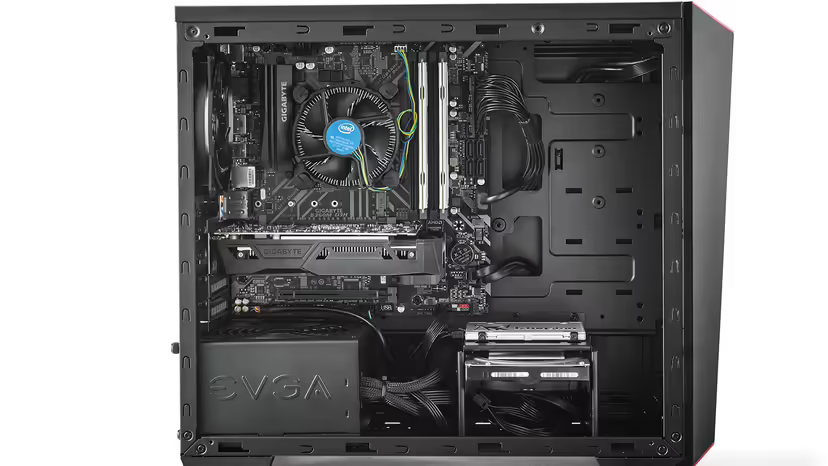

# What is a computer cluster

* Simply many computers mounted connected into a local area network LAN
![Mathias at Glenn](mathias_at_glenn.jpg)

* Typically rack mounted and connected with a fast network
* One node == one computer
   * From 10 to 40 per rack is common
   * Login nodes
* Associated storage cluster
   * Again just computers with many harddrives working over network


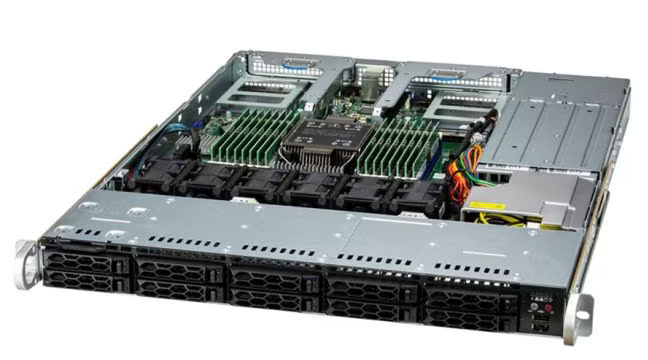

# Hardware differences

* **Typical** differences for a single node
* Enterprise hardware has support contracts and is made to be running at load nonstop for years.

## CPU
* Much more CPU cores (up to 128 are common today)
* Typically *slower* for single core work
  * Boost speeds up to 5GHz on a gaming PC, 3.7 GHz on high end cluster CPUs
* Often dual socket: two CPU on a single motherboard
* Larger vector instructions for floating point math (AVX512)

## Memory
* Much more (512GB and up per node is common these days)
* Error Correcting Code (ECC) memory is more reliable and can detect and random bit errors
* Note that memory, disk space, and VRAM are physically different hings all measured in bytes.

## Network
* Faster ethernet, from 25Gbit/s to 200Gbit/s
* Infiniband, alternative to Ethernet
  * Lower latency (as much as an order of magnitude)
  * Advanced features such as RDMA (remote direct memory access: GPUs copying data directly to other GPUs)
  * Often even faster (56Gbit/s up to 400Gbit/s)

## Storage
* Local disks are not used for persistent storage of user data
* Primary data access is done via a network attached storage cluster
* Storage is more reliable; protection to small hardware failures via redundant hardware (RAID) and backups
* Network storage is very sensitive to access pattern
  * Random read access and such can kill performance.

### Note:
* Single harddrives are notoriously unreliable: you must always keep several backups of your data.
* Note that RAID does not protect you from accidentally deleting/overwriting your own data.

## GPU
* Some compute nodes don't have any GPUs
* 4 GPUs per node
* More VRAM ("video" RAM) up to 80GB
* GPUs are customized hardware for various floating point types

## GPU performance exmaple
| GPUs    | FP16 TFLOP/s | FP32 | FP64 | Capability |
|---------|--------------|------|------|------------|
| V100    |         31.3 | 15.7 |  7.8 |        7.0 |
| T4      |         65.1 |  8.1 | 0.25 |        7.5 |
| A40     |         37.4 | 37.4 | 0.58 |        8.6 |
| A100    |         77.9 | 19.5 |  9.7 |        8.0 |
| **CPU node** |         |      |      |            |
| Skylake |              | ~4   | ~2   | (32 cores) |
| Icelake |              | ~8   | ~4   | (64 cores) |

* Theoretical numbers!

# User differences

* Laptop/desktop
  * Single user
  * Administrative privileges
  * Software installed manually by user via OS or downloads
  * Just run the software directly on the computer

* Cluster
  * Multi user
  * No elevated privileges
  * Software installations 
  * Interacting with a login node, submitting jobs to queue
    * Mostly batch computations
    * Interactive jobs are possible, but there is still a queue
    * Light interactive post-processing can be done on login node


# The compute cluster
![The cluster environment](cluster_sketch.svg)

## Preparing job
![Prepare jobs on login node](cluster_work_on_login.svg)

* Install your own software (if needed)
* Login nodes are shared resources!
* Transfer input files to the cluster
* Prepare batch scripts for how perform your analysis


## Submit job
![Submit job to queue](cluster_submit_job.svg)

* Submit job script to queuing system (sbatch)
* You'll have to specify number of cores, wall-time, GPU/large memory
* Job is placed in a queue ordered by priority (influenced by usage, project size, job size)

## Job starts
![Job starts when node are available](cluster_job_starts.svg)

* Job starts when requested nodes are available (and it is your turn)
* Automatic environment variables inform MPI how to run (which can run over Infiniband)
* Performs the actions you detailed in our job script as if you were typing them in yourself

# Connecting
* SSH: `ssh CID@vera1.c3se.chalmers.se` or `CID@vera2.c3se.chalmers.se`
* Thinlinc: <https://vera1.c3se.chalmers.se:300> or <https://vera1.c3se.chalmers.se:300>
  * Also has a dedicated client for linux, mac, windows
* OpenOndemand: <https://vera.c3se.chalmers.se>
  * Conveniently launch interactive applications in the queue
  * Also allows graphical desktop on either compute node (via queue) or login node like Thinlinc

# Parallel computations

* Moving a program to a HPC environment doesn't magically make it faster.
* Programs need to consider how to parallelize things manually.

## Embarrasingly parallel jobs
* The simplest parallelization is to simple run different the same analysis on different inputs

```bash
#!/bin/bash
#SBATCH -A C3SE2021-2-3
#SBATCH -n 1
#SBATCH -C MEM512  # my computation needs 1/64 * 512GB = 8GB of RAM per task
#SBATCH -t 1:00:00
#SBATCH --array=0-99
#SBATCH --mail-user=zapp.brannigan@chalmers.se --mail-type=end

module load SciPy-bundle

process_data.py input_data_${SLURM_ARRAY_TASK_ID}.npz results_${SLURM_ARRAY_TASK_ID}.txt
```

* Need to produce a plot or table with all the combined results? Split that into seperate postprocessing.
* Need millions of analysis? Do them in batches or look into High-Throughput-Computing software like `hyperqueue`


## Vector instructions

* All modern CPUs have some vector instruction sets allowing them to do multiple binary operations simultaenously on a single core.
* SIMD - Single Instruction Multiple Data
* AVX512 (2015) > AVX2 (2008) > AVX (2011) > SSE (1999-2006) > Generic instructions (<1996).
* Has strict requirements on memory layout.
* Most of the time one relies on optimized libraries doing the heavy lifting.
* All of Vera's CPUs support AVX512.
* You should make your code fast one a single core first!

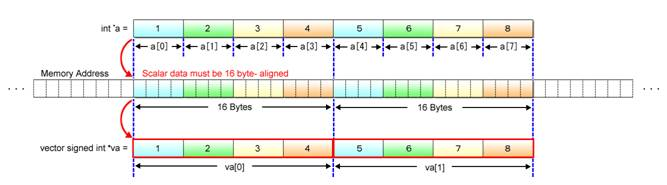

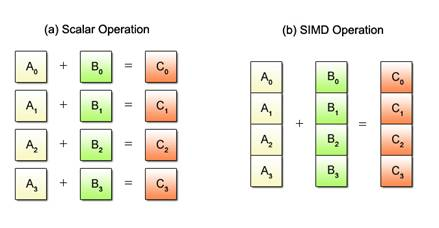

## Shared memory

* Many programming languages can dynamically launch multiple threads to speed up computations
* Threads a lightweight processes that can be spun up extremely quickly
* Multiple threads of computation running and sharing memory
  * You have to program in that no two threads should read and write to the same memory at the same time (race condition)
  * Typical example of parallelizing a for loop with OpenMP

```c
#pragma omp parallel for
for(int i = 0; i < ARRAY_SIZE; i++) {
    results[i] = a[i] / b[i];
}
```

* Using optimized libraries can hide away this complexity and use multiple threads under the hood.
* Software using OpenMP framework can typically be controlled via environment variables like `OMP_NUM_THREADS`

## Shared memory in python
* Python itself can't do actual multithreading
  * `multiprocessing` actually starts multiple interpreters and copies memory to them. They can't see the same memory (like a large shared read-only block of data).
  * Python 3.13 allows for free threading mode, though still highly experimental and support is nonexistent.
  * Libraries (`numpy` etc.) may have C/C++/Rust code that can use multiple threads internally.
* Numba can just-in-time compile multithreaded "python" (with *many* restrictions)

In [ ]:
from numba import njit

@njit(parallel=True)
def parallel_sum(arr):
    total = 0.0
    for i in prange(len(arr)):
        total += arr[i]
    return total

In [ ]:
import numpy as np
from numba import njit, prange, set_num_threads
set_num_threads(4)

# Intentionally bad algorithm to make it slow enough to demonstrate.

@njit
def is_prime(n):
    if n < 2:
        return False
    for i in range(2, n):
        if n % i == 0:
            return False
    return True

@njit(parallel=True)
def check_all_primes(arr):
    for i in prange(len(arr)):
        if not is_prime(arr[i]):
            return False
    return True

arr = np.array([2000003861, 2000003867, 2000003891, 2000003963])
result = check_all_primes(arr)
print("All numbers are prime:", result)

In [ ]:
@njit(parallel=True)
def is_prime(n):
    if n < 2:
        return False
    divisors = 0
    for i in prange(2, n):
        divisors += int(n % i == 0)
    return divisors == 0

@njit
def check_all_primes(arr):
    for i in range(len(arr)):
        if not is_prime(arr[i]):
            return False
    return True

result = check_all_primes(arr)
print("All numbers are prime:", result)

In [ ]:
def is_prime(n):
    if n < 2:
        return False
    divisors = 1
    for i in range(2, int(np.sqrt(n)) + 1):
        divisors *= n % i 
    return divisors != 0

In [ ]:
is_prime(26863)

In [ ]:
x = [26849, 26861, 26863, 26879, 26881, 26891, 26893, 26903]
[is_prime(y) for y in x]

## Distributed memory

* Multiple individual processes all not sharing memory access.
* Messages must be explicitly passed between processes to synchronize information: Message Passing Interface (MPI) is the standard.
* Optional within a single node. Required when scaling to multiple nodes.
* Software can use both modes; MPI across nodes + OpenMP inside nodes is common.

In [ ]:
from mpi4py import MPI
import numpy as np

comm = MPI.COMM_WORLD  # Get the global communicator
rank = comm.Get_rank()  # Get the rank of the current process
size = comm.Get_size()  # Get the total number of processes

# Total size of the array
N = 100

# The root process initializes the data
if rank == 0:
    data = np.arange(N, dtype=np.float64)
    print(f"Process {rank} initializing data: {data}")
else:
    data = None

# Scatter the data: distribute chunks of the array to all processes
chunk_size = N // size
local_data = np.empty(chunk_size, dtype=np.float64)
comm.Scatter(data, local_data, root=0)

# Each process computes the sum of its local chunk
local_sum = np.sum(local_data)
print(f"Process {rank} computed local sum: {local_sum}")

# Gather the local sums at the root process
total_sum = comm.reduce(local_sum, op=MPI.SUM, root=0)

# Root process prints the total sum
if rank == 0:
    print(f"Total sum: {total_sum}")

## MPI is not the only option

* Consider for `python`:
  * <https://www.ray.io>
  * <https://www.dask.org>
  * <https://github.com/modin-project/modin> - drop-in parallel `pandas` replacement
  * <https://numba.pydata.org>

In [ ]:
from dask.distributed import Client, progress
import dask

client = Client()

def square(x):
    return x ** 2

numbers = list(range(10))

futures = client.map(square, numbers)
results = client.gather(futures)

print("Squared values:", results)
print("Sum of squares:", sum(results))

client.close()

In [ ]:
import ray
import time

ray.init()

@ray.remote
def compute_square(x):
    time.sleep(1)  # Simulate a time-consuming task
    return x * x

numbers = [1, 2, 3, 4, 5]

results = [compute_square.remote(num) for num in numbers]

squares = ray.get(results)

print(f"Squares: {squares}")

ray.shutdown()

# Running jobs in a cluster

* Prepare your data and programs on the login node
* Prepare a jobscript
* Monitor your jobs
* Profile your application

## Jobscripts

* What Account == Project to run on
* Request a maximum walltime
* Number of tasks, cpus-per-task, gpus-per-task, cpus-per-gpu, and many other optional steps.
* Constrain jobs to a specific node type, typically larger memory nodes.
* Other types of resource tracked by SLURM like GPUs of various types.

## Jobscript example

```bash
#!/usr/bin/env bash
#SBATCH -A C3SE2024-1-2 -p vera
#SBATCH -t 1:00:00
#SBATCH -n 4

# run your program
module load SciPy-bundle/2024.05-gfbf-2024a

export OMP_NUM_THREADS=$SLURM_NTASKS
python3 compute_stuff.py
```

## Arrays of jobs

* Again; if your entire process (except for maybe some light postprocessing) is independent; no need to parallelize in your own code. Just run many jobs!
* SLURM gives you a variable `SLURM_ARRAY_TASK_ID` to use, i.e. for numbered input files: `image_1.png`, `image_2.png`, ... can be `image_${SLURM_ARRAY_TASK_ID}.png`
* You can use this value directly in your Python script:

```python
import os
import numpy

seed = int(os.getenv('SLURM_ARRAY_TASK_ID'))
numpy.random.seed(seed)
x = numpy.random.rand(3, 3)
a, b = np.linalg.eig(np.random.rand(3,3))
print(a[0])
```

* Do you have +100000 of small tasks? That's to much for slurm as individual jobs. Please use Ray/dask/Hyperqueue etc. 

## Monitor your jobs

1. Check the queue: `squeue -u $USER`
   * Is it running on what you wanted?
   * If you don't see it, maybe it just finished really really quick, check the SLURM accounting database `sacct -u $USER`
2. Check the output files for errors or warnings.
3. Check the grafana page: `job_stats.py JOBID` which reveals if there are obvious bottlenecks. 

## Profile your application

* Compiled C, C++, Fortran etc. (make sure you include debug symbols)
  * Intel VTune, AMD uProf, NVIDIA Nsight
* Python
  * Scalene (and many more)
* Most of these tools are sampling your code at runtime: results are not exact and may have some overhead.
* Common bottlenecks can be
  * Disk I/O: How you read data is very important, especially on a network attached parallel filesystem!
  * Memory access: Random memory access patterns can slow down the CPU 100x. Sequential memory reads are better.
  * GPU syncs: Excessive syncing with GPUs can be much slower than the entire calculation

# Accelerators (GPUs)

* Originally made for graphics rendering but that's just lots of linear algebra.
* Typically good at FP32 and below whereas scientific computing on CPUs has generally used FP64 (double precision).
  * Newton iteration; accuracy isn't important for the tangent problem
  * Iterative problems can start with FP16 then switch to FP32, FP64 for fine tuning


![FP32](Float_example.svg)

* GPUs are inherently parallel-only: your problem needs to at least be divisible to hundreds (or thousands) of parts for it to make much sense on a GPU.
* Requires careful planning and use to obtain good performance.
  * Sync too often and you kill any performance gain.

## Writing custom CUDA kernels

* Possile to do in many langauges: C, C++, Julia, Python (via `numba`)
* Difficulty can vary

In [ ]:
from numba import cuda

@cuda.jit
def vector_add_kernel(A, B, C):
    i = cuda.grid(1)    
    C[i] = A[i] + B[i]

## GPU arrays

* Simple GPU array types is offered by many frameworks in most programming languages.
* Are you used to vectorizing using numpy arrays? Almost the same thing!
* Examples <https://docs.cupy.dev/en/stable/user_guide/basic.html>

* Some libraries for python:
  * <https://github.com/rapidsai> (cuDF and many more)
  * <https://cupy.dev>
  * <https://jax.readthedocs.io>
  * <https://pytorch.org> (you could use tensors for general linear algebra)

## Asynchronous computing

* Codes speak to many things outside of memory that work independent of the CPU:
  * GPUs
  * Networking
  * Filesystems
* The CPU could just wait for each of those results before starting the next:

### Demonstration

* Lets see the principles here

In [ ]:
%%writefile data.txt
0.1 2.3 3.4
4.3 3.2 1.0
0.2 3.1 4.0
3.2 4.2 0.4

In [ ]:
import cupy as cp

A = cp.array([[3, 1, 2], [1, 2, 1], [0, 3, 3]], dtype=cp.float32)

results = []
with open('data.txt') as f:
    for line in f:
        b = [float(x) for x in line.split(' ')]  # GPU waiting for CPU
        b = cp.array(b, dtype=cp.float32)
        x = cp.linalg.solve(A, b)
        
        results.append(x.get()) # Copy the data back from the GPU to RAM.

print(results)

* Here we half the CPU, wait for the external resource (the GPU) to finish and give us the results, before we proceed to parse the next line of data (during which the GPU is waiting for us)
* Instead, asynchronously prep the next data:

In [ ]:
results = []

with open('data.txt') as f:
    for line in f:
        b = [float(x) for x in line.split()]
        b = cp.array(b, dtype=cp.float32)
        x = cp.linalg.solve(A, b)
        results.append(x)  # Doesn't block

results = [x.get() for x in results]
print(results)